In [239]:
import sys
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib as plt
import comparativesrna as srna
import json

run_all = False

print (sys.version)
print(sys.executable)

3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
/Users/thomasnicholson/anaconda3/bin/python


In [187]:
alignment_file_counts = pd.read_csv("/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/original_stats_all.txt", 
                                    header=None, delim_whitespace=True, names=list('abcdef'))
alignment_file_counts = alignment_file_counts.loc[alignment_file_counts['a'] == 'Number_of_sequences:']
alignment_file_counts = alignment_file_counts[['b', 'c']]
alignment_file_counts.columns = ['count', 'id']
alignment_file_counts['id'] = alignment_file_counts['id'].str.replace('.stk', '')
alignment_file_counts.set_index('id', inplace=True)
target_counts = alignment_file_counts.to_dict()

alignDat = pd.read_csv("/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/predicted_genomic_sequence_matches.txt", header=None, delim_whitespace=True)
alignDat = alignDat.iloc[:,[1,3]]
alignDat.columns = ["details", "query_id"]
alignDat[["target_contig", "coord"]] = alignDat.details.str.split("/", expand = True)
alignDat[["target_start", "target_end"]] = alignDat.coord.str.split("-", expand = True)
alignDat = alignDat[["query_id", "target_contig", "target_start", "target_end"]]
alignDat["target_start"] = alignDat["target_start"].astype(str).astype(int)
alignDat['target_start'].dtypes
alignDat["target_end"] = alignDat["target_end"].astype(str).astype(int)
alignDat['target_end'].dtypes
alignDat = alignDat.sort_values(by=['target_start'])
display(alignDat)

,query_id,target_contig,target_start,target_end
102257,GCA_000283715.1_608,NC_016824.1,1,502
97980,GCA_000281215.1_63,NC_004578.1,1,169
143061,GCA_002208745.1_77,NC_004578.1,1,196
18031,GCA_000017745.1_1104,NZ_CP014273.1,1,88
49730,GCA_000017765.1_1,NC_004741.1,2,139
...,...,...,...,...
237016,GCA_900243355.1_880,NC_004129.6,7072550,7072638
237049,GCA_900243355.1_881,NC_004129.6,7073958,7074088
10609,GCA_000007565.2_2,NC_004129.6,7074572,7074786
97979,GCA_000281215.1_63,NC_004129.6,7074629,7074825


In [188]:
target_contigs = alignDat.target_contig.unique()
query_ids = alignDat.query_id.unique()

In [200]:
if run_all == True:
    overlapping_ids = []
    lengths = []
    start_val = 0
    end_val = 0
    overlaps = []
    for contig in target_contigs:
        subsetDat =  alignDat.loc[alignDat['target_contig'] == contig]
        overlaps = srna.get_overlap_vals(subsetDat, overlaps)
    df = pd.DataFrame(data = overlaps)
    df.to_csv('/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/overlaps_data.csv', index=False)
    else:
        overlaps = pd.read_csv("/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/overlaps_data.csv", header=None, delim_whitespace=True)


In [207]:
overlaps[:10]

[1.0,
 0.9047619047619048,
 0.8988095238095238,
 1.0,
 1.0,
 1.0,
 0.239247311827957,
 1.0,
 1.0,
 1.0]

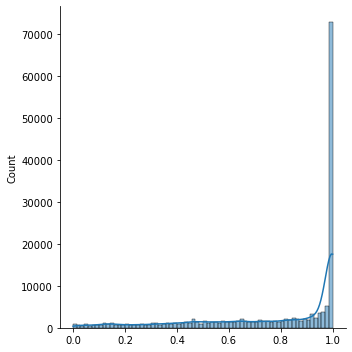

<Figure size 5760x5760 with 0 Axes>

In [228]:
import matplotlib as plt
from matplotlib.pyplot import figure
fig = sns.displot(overlaps, kde=True)
figure(figsize = (80,80))
fig.savefig("/Users/thomasnicholson/phd/RNASeq/figures/displot.svg", dpi=100)

In [246]:
if run_all == True:
    d = {}
    for contig in target_contigs:
        print(contig)
        subsetDat =  alignDat.loc[alignDat['target_contig'] == contig]
        overlap_list = srna.get_overlap_list(subsetDat = subsetDat)
        d = srna.get_overlap_count(overlap_list = overlap_list, d = d)
        json_data = json.dumps(d)
        file = open('/Users/thomasnicholson/phd/RNASeq/python_files/dict.json', 'w')
        file.write(json_data)
        file.close()
else:
    with open('/Users/thomasnicholson/phd/RNASeq/python_files/dict.json', 'r') as read_file:
        d = json.load(read_file)

In [85]:
if run_all == True:
    query_matches = {}
    query_counts = {}
    overlap_percentages = []
    threshold = 0
    for i in range(0, len(query_ids) -1):
        for j in range(i + 1, len(query_ids)):
            ids =[query_ids[i], query_ids[j]]
            ids.sort()
            current_id = "_".join(ids)
            count = min([target_counts['count'][query_ids[i]], target_counts['count'][query_ids[j]]])
            count = int(count)
            if current_id in d:
                if d[current_id]/count < 1 and d[current_id]/count > threshold:
                    overlap_percentages.append(d[current_id]/count)
                else:
                    overlap_percentages.append(1)
                if d[current_id]/count > threshold:
                    query_matches[current_id] = d[current_id]/count
                    query_counts[current_id] = [d[current_id]/count, count, d[current_id]]
    json_query_matches = json.dumps(query_matches)
    file = open('/Users/thomasnicholson/phd/RNASeq/python_files/query_matches.json', 'w')
    file.write(json_query_matches)
    file.close()
    json_query_counts = json.dumps(query_counts)
    file = open('/Users/thomasnicholson/phd/RNASeq/python_files/query_counts.json', 'w')
    file.write(json_query_counts)
    file.close()
else:
    with open('/Users/thomasnicholson/phd/RNASeq/python_files/query_counts.json', 'r') as read_file:
        query_counts = json.load(read_file)


In [259]:
if run_all == True:
    all_overlaps = {}
    ids_checked = []
    for key, value in d.items():
        ids = key.split("_")
        id1 = "_".join(ids[:3])
        id2 = "_".join(ids[3:])
        all_overlaps, ids_checked, make_new, counter = srna.unique_set_of_overlaps(all_overlaps, ids_checked, id1 = id1, id2 = id2)
        all_overlaps, ids_checked, make_new, counter = srna.unique_set_of_overlaps(all_overlaps, ids_checked, id1 = id2, id2 = id1)
        if make_new == True:
            all_overlaps[id1] = [id2]
    json_all_overlaps = json.dumps(all_overlaps)
    file = open('/Users/thomasnicholson/phd/RNASeq/python_files/all_overlaps.json', 'w')
    file.write(json_all_overlaps)
    file.close()
else:
    with open('/Users/thomasnicholson/phd/RNASeq/python_files/all_overlaps.json', 'r') as read_file:
        all_overlaps = json.load(read_file)    

In [112]:
key =  'GCA_002208745.1_77_GCA_002208745.1_78'
ids = key.split("_")
id1 = "_".join(ids[:3])
id2 = "_".join(ids[3:])
if id2 in ids_checked:
    if id2 in all_overlaps:
        print(id2)
    else:
        for item in all_overlaps:
            if id2 in all_overlaps[item]:
                print(item, all_overlaps[item]) 


GCA_000281215.1_63 ['GCA_002208745.1_78', 'GCA_000007565.2_1', 'GCA_002208745.1_78', 'GCA_002208745.1_78', 'GCA_002208745.1_78', 'GCA_000007565.2_2', 'GCA_000281215.1_216', 'GCA_002208745.1_78', 'GCA_000006765.1_1']
GCA_002208745.1_77 ['GCA_002208745.1_78', 'GCA_000007565.2_1', 'GCA_002208745.1_78', 'GCA_000281215.1_216', 'GCA_002208745.1_78', 'GCA_000007565.2_2', 'GCA_002208745.1_78', 'GCA_000006765.1_1']
GCA_000007565.2_2 ['GCA_002208745.1_78']


In [173]:
number_of_ids_overlapping = {}

for key, value in all_overlaps.items():
    number_of_ids_overlapping[key] = [len(value)]

df = pd.DataFrame(number_of_ids_overlapping)
df = df.T
df.columns = ['id_count']

df.index.name = 'id1'
df.reset_index(inplace=True)

In [174]:
df.to_csv('/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/representative_ids.csv', index=False)

In [80]:
overlap_percentages_2 = []
for key, value in query_counts.items():
    overlap_percentages_2.append(value[0])

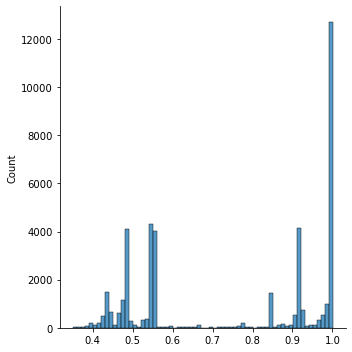

In [86]:
sns.displot(overlap_percentages_2, binwidth = 0.01)

In [72]:
df = pd.DataFrame.from_dict(query_counts, orient='index', columns = ['percentage', 'total', 'count'])
df.index.name = 'id'
df.reset_index(inplace=True)
df

,id,percentage,total,count
0,GCA_000281215.1_63_GCA_002208745.1_77,1.0000,16,16
1,GCA_000007565.2_2_GCA_000281215.1_63,0.4375,16,7
2,GCA_000017745.1_1104_GCA_000017765.1_281,0.8429,331,279
3,GCA_000007405.1_589_GCA_000497505.1_329,1.0000,19,19
4,GCA_000497505.1_329_GCA_000747565.1_531,0.7000,20,14
...,...,...,...,...
42268,GCA_000281215.1_288_GCA_000281215.1_289,1.0000,2,2
42269,GCA_000281215.1_289_GCA_000281215.1_301,1.0000,2,2
42270,GCA_000006765.1_838_GCA_900243355.1_755,1.0000,4,4
42271,GCA_000006765.1_841_GCA_900243355.1_774,1.0000,4,4


In [74]:
df.to_csv('/Users/thomasnicholson/phd/RNASeq/srna_seqs/version_1/predicted/overlap_values_3.csv', index=False)

In [27]:
combined_d = {}
ids_checked = []
for query in query_ids:
    if query not in ids_checked:
        combined_d, ids_checked = srna.combined_alignments(query = query, combined_d = combined_d, ids_checked = ids_checked, query_matches = query_matches)


In [28]:
full_list = []
for key, value in combined_d.items():
    for item in value:
        full_list.append(item)
unique_list = []
for key, value in combined_d.items():
    for item in value:
        if item not in unique_list:
            unique_list.append(item)
        else:
            print(item)

In [162]:
test_contigs = ['N1', 'N2', 'N3', 'N4']
test_data = {'query_id':['G1', 'G2', 'G3', 'G1', 'G2', 'G3', 'G1', 'G1', 'G3', 'G3', 'G2', 'G3'], 
             'target_contig':['N1', 'N1', 'N1', 'N2', 'N2', 'N2', 'N3', 'N3', 'N3', 'N3', 'N4', 'N4'],
            'target_start':[1, 1, 2, 100, 100, 100, 940, 855, 940, 855, 1010, 1015],
            'target_end':[100, 100, 95, 180, 180, 180, 860, 935, 860, 935, 1110, 1120]}
test_dat = pd.DataFrame(test_data)
print(test_dat)


   query_id target_contig  target_start  target_end
0        G1            N1             1         100
1        G2            N1             1         100
2        G3            N1             2          95
3        G1            N2           100         180
4        G2            N2           100         180
5        G3            N2           100         180
6        G1            N3           940         860
7        G1            N3           855         935
8        G3            N3           940         860
9        G3            N3           855         935
10       G2            N4          1010        1110
11       G3            N4          1015        1120


In [61]:
test_d = {}
for contig in test_contigs:
    print(contig)
    subsetDat =  test_dat.loc[test_dat['target_contig'] == contig]
    print(subsetDat)
    overlap_list = get_overlap_list(subsetDat = subsetDat)
    print(overlap_list)
    test_d = get_overlap_count(overlap_list = overlap_list, d = test_d)

N1
  query_id target_contig  target_start  target_end
0       G1            N1             1         100
1       G2            N1             1         100
2       G3            N1             2          95
[[], ['G1', 'G2', 'G3']]
N2
  query_id target_contig  target_start  target_end
3       G1            N2           100         180
4       G2            N2           100         180
5       G3            N2           100         180
[[], ['G1', 'G2', 'G3']]
N3
  query_id target_contig  target_start  target_end
6       G1            N3           940         860
7       G1            N3           855         935
8       G3            N3           940         860
9       G3            N3           855         935
[[], ['G1', 'G3']]
N4
   query_id target_contig  target_start  target_end
10       G2            N4          1010        1110
11       G3            N4          1015        1120
[[], ['G2', 'G3']]


In [62]:
test_d

{'G1_G2': 2, 'G1_G3': 3, 'G2_G3': 3}